<h1 style="text-align:center">Two-link Planar Robot Arm</h1>
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>

In [1]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols
from sympy.physics.mechanics import inertia, LagrangesMethod, Lagrangian
from sympy.physics.mechanics import Particle, Point, ReferenceFrame, RigidBody

# initiate better printing of SymPy results
sympy.init_printing()

In [2]:
# Define the genearlized coordinate
theta1, theta2, Torq1, Torq2 = dynamicsymbols('theta_1 theta_2 tau_1 tau_2')

# Also define the first derivative
theta1_dot, theta2_dot = dynamicsymbols('theta_1 theta_2', 1)

# Define the symbols for the other paramters
m1, m2, l1, l2, I1, I2, t = sympy.symbols('m_1 m_2 l_1 l_2 I_1 I_2 t')

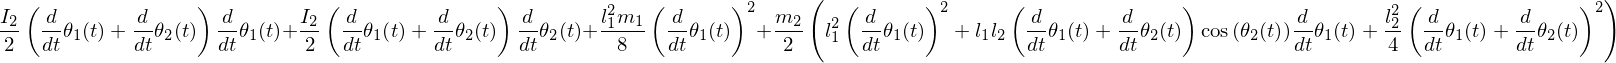

In [3]:
# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define a body-fixed frames
A = N.orientnew('A', 'Axis', [theta1, N.z]) # Fixed to link 1
B = A.orientnew('B', 'Axis', [theta2, A.z]) # Fixed to link 2

# Define an origin and set its velocity to 0
O = Point('O')
O.set_vel(N, 0 * N.x)

# Define the COM of the first link location and velocity
G1 = O.locatenew('G1', l1/2 * A.x)
G1.v2pt_theory(O, N, A)

# Define the point at the end of the first link and set its velocity
P = O.locatenew('P', l1 * A.x)
P.v2pt_theory(O, N, A)

# Define the COM of the first link location and velocity
G2 = P.locatenew('G2', l2/2 * B.x)
G2.v2pt_theory(P, N, B)

# Create the first link rigid bogy
I_link1 = inertia(A, 0, 0, I1)
link1 = RigidBody('link1', G1, N, m1, (I_link1, G1))

# Create the second link rigid bogy
I_link2 = inertia(B, 0, 0, I2)
link2 = RigidBody('link2', G2, B, m2, (I_link2, G2))

# Now, set the potential energy of the links
# Both are zero
link1.potential_energy = 0
link2.potential_energy = 0

# Set up the force list - each item follows the form:
#    (the location where the force is applied, its magnitude and direction)
forces = [(A, (Torq1-Torq2) * A.z), (B, Torq2 * B.z)]

# # Form the Lagrangian
L =  Lagrangian(N, link1, link2)

# # Print the Lagrangian as a check
L

In [4]:
# This creates a LagrangesMethod class instance that will 
# allow us to form the equations of motion, etc
LM = LagrangesMethod(L, [theta1, theta2], forcelist=forces, frame=N)

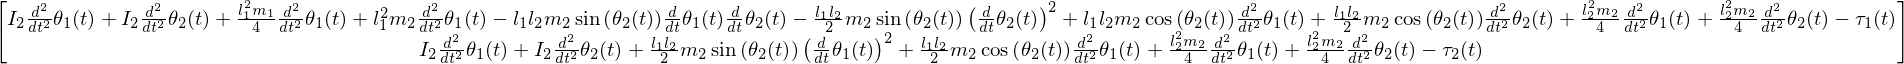

In [5]:
# Form the equations fo motion
EqMotion = LM.form_lagranges_equations()

# Print the simplified version of the equations of motion
sympy.simplify(EqMotion)

The <tt>LagrangesMethod</tt> class gives us lots of information about the system. For example, we can output the mass/inertia matrix and the forcing terms. Note that the forcing terms include what might be conservative forces and would therefore normally appear in a stiffness matrix.`m

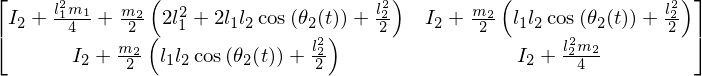

In [6]:
# Output the inertia/mass matrix of the system
LM.mass_matrix

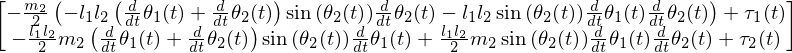

In [7]:
# Output the forcing terms of the system
LM.forcing

We can also use builtin functions to write the system as a set of first order ODEs, suitable for simluation.

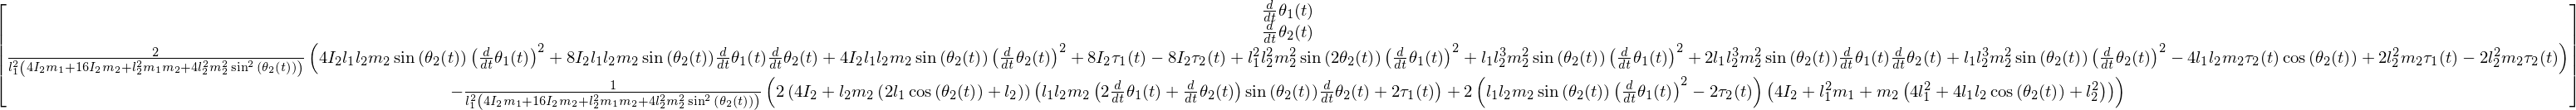

In [8]:
# This can be a very expensive call to make, if you don't need it

# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

# Simplify the results
lrhs.simplify()

# Output the result
lrhs

## Simulation
We can pass these equations of motion to numerical solver for simluation. To do so, we need to import [NumPy](http://numpy.org) and the [SciPy](http://www.scipy.org) ode solver, ```ode```. We'll also import [matplotlib](http://www.scipy.org) to enable plotting of the results.

In [9]:
# import NumPy with namespace np
import numpy as np

# import the scipy ODE solver
from scipy.integrate import odeint

# import the plotting functions from matplotlib
import matplotlib.pyplot as plt

# set up the notebook to display the plots inline
%matplotlib inline

In [10]:
# define the forcing function
def torq(t):
    # set the maximum torque output
    torq_max = 100.0
    
    # return a bang-bang command
    return torq_max * (t > 0.5) - 2 * torq_max * (t > 1.0) + torq_max * (t > 1.5)

def tau_1(t):
    return 2*torq(t)

def tau_2(t):
    return torq(t)    

In [11]:
def eq_of_motion(w, t, p):
    """ Equations of motion for the two link system"""
    
    theta_1, theta_2, theta_1_dot, theta_2_dot = w
    m_1, m_2, l_1, l_2, I_1, I_2 = p
    
    sys_ode = [theta_1_dot,
               theta_2_dot,
               2*(4*I_2*l_1*l_2*m_2*np.sin(theta_2)*theta_1_dot**2 + 8*I_2*l_1*l_2*m_2*np.sin(theta_2)*theta_1_dot*theta_2_dot + 4*I_2*l_1*l_2*m_2*np.sin(theta_2)*theta_2_dot**2 + 8*I_2*tau_1(t) - 8*I_2*tau_2(t) + l_1**2*l_2**2*m_2**2*np.sin(2*theta_2)*theta_1_dot**2 + l_1*l_2**3*m_2**2*np.sin(theta_2)*theta_1_dot**2 + 2*l_1*l_2**3*m_2**2*np.sin(theta_2)*theta_1_dot*theta_2_dot + l_1*l_2**3*m_2**2*np.sin(theta_2)*theta_2_dot**2 - 4*l_1*l_2*m_2*tau_2(t)*np.cos(theta_2) + 2*l_2**2*m_2*tau_1(t) - 2*l_2**2*m_2*tau_2(t))/(l_1**2*(4*I_2*m_1 + 16*I_2*m_2 + l_2**2*m_1*m_2 + 4*l_2**2*m_2**2*np.sin(theta_2)**2)),
               -(2*(4*I_2 + l_2*m_2*(2*l_1*np.cos(theta_2) + l_2))*(l_1*l_2*m_2*(2*theta_1_dot + theta_2_dot)*np.sin(theta_2)*theta_2_dot + 2*tau_1(t)) + 2*(l_1*l_2*m_2*np.sin(theta_2)*theta_1_dot**2 - 2*tau_2(t))*(4*I_2 + l_1**2*m_1 + m_2*(4*l_1**2 + 4*l_1*l_2*np.cos(theta_2) + l_2**2)))/(l_1**2*(4*I_2*m_1 + 16*I_2*m_2 + l_2**2*m_1*m_2 + 4*l_2**2*m_2**2*np.sin(theta_2)**2))]
    
    return sys_ode

In [12]:
# Set up the initial conditions for the solver
theta1_init = 90.0 * np.pi/180  # Initial angle (rad)
theta1_dot_init = 0.0           # Initial angular velocity (rad/s)
theta2_init = 0.0 * np.pi/180  # Initial angle (rad)
theta2_dot_init = 0.0           # Initial angular velocity (rad/s)

# Pack the initial conditions into an array
x0 = [theta1_init, theta2_init, theta1_dot_init, theta2_dot_init]

# Define the numerical values for all the system constants
# and pack them into a list for passing
m1 = 10.0
m2 = 10.0
l1 = 2.0
l2 = 2.0 
I1 = 1/12 * m1 * l1**2
I2 = 1/12 * m2 * l2**2

p = [m1, m2, l1, l2, I1, I2]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 5.0, 5001) # 0-10s with 1001 points in between

In [13]:
# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01

# Call the ODE solver.
resp = odeint(eq_of_motion, x0, sim_time, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

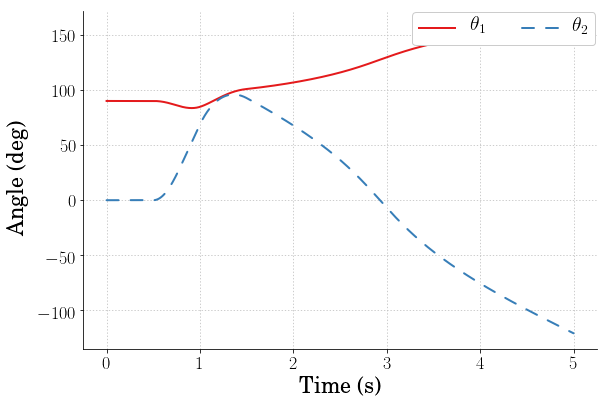

In [14]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, resp[:, 0] * 180/np.pi, linewidth=2, linestyle='-', label = r'$\theta_1$')
plt.plot(sim_time, resp[:, 1] * 180/np.pi, linewidth=2, linestyle='--', label = r'$\theta_2$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(-1, 5)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('TwoLinkArm_AngularResponse.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

In [15]:
# Now, let's define the planar positions of the elbow joint and endpoint
# Then, we'll plot them on a planar representation of the workspace
elbow_x = l1 * np.cos(resp[:,0])
elbow_y = l1 * np.sin(resp[:,0])
end_x = elbow_x + l2 * np.cos(resp[:,0] + resp[:,1])
end_y = elbow_y + l2 * np.sin(resp[:,0] + resp[:,1])

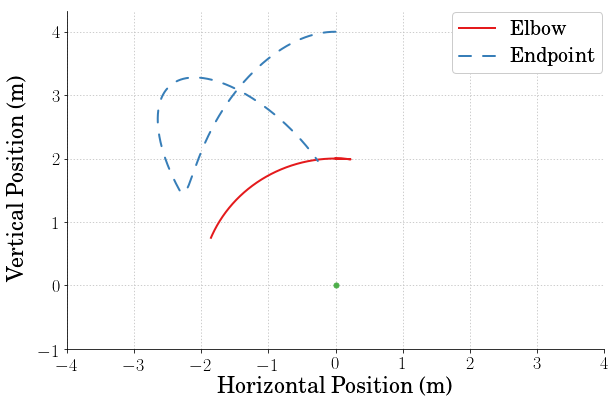

In [16]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Horizontal Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(elbow_x, elbow_y, linewidth=2, linestyle='-', label = r'Elbow')
plt.plot(end_x, end_y, linewidth=2, linestyle='--', label = r'Endpoint')
plt.plot(0,0, linestyle='', marker='o', markersize=5, label ='', zorder = 99)

# uncomment below and set limits if needed
plt.xlim(-4, 4)
plt.ylim(-1, 4+1/3)

# Create the legend, then fix the fontsize
leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
ltext  = leg.get_texts()
plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('TwoLinkArm_PlanarResponse.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [17]:
# This cell will just improve the styling of the notebook
# You can ignore it, if you are okay with the default sytling
from IPython.core.display import HTML
import urllib.request
response = urllib.request.urlopen("https://cl.ly/1B1y452Z1d35")
HTML(response.read().decode("utf-8"))